# Computer intensive methods

## Homework 1 - 29 September 2015

### Question 1: Correlation of law school data

We want to estimate the correlation between the LSAT and GPA score of USA law schools based on a random sample of $n = 15$ schools. The dataset was retrived from the R package *bootstrap* (https://cran.r-project.org/web/packages/bootstrap/index.html). We will utilise the amazing Python package Numpy, which adds support for elegant array operations and a large library of mathematical and statistical functions (http://www.numpy.org/).

In this first step we import the numpy package. We will also load the pandas package, which adds support for data frames akin to R and are sometimes a bit more intuitive to work with. We will be using both numpy arrays and panda dataframes interchangeably throughout this tutorial, to show the capabilities of both. The last few imports are required to plot graphics in this Jupyter notebook. 

Next, we read in the data in a 2-dimensional array and convert it to a data frame with named columns.

In [1]:
import math
import numpy as np # Imports the numpy package for easy matrix manipulation
import pandas as pd # Imports the pandas package for data frame manipulation
import matplotlib # Imports plotting capabilities
import matplotlib.pyplot as plt
from matplotlib import style # Sets graphics style
style.use('ggplot')
%matplotlib inline

law = np.array([[576, 635, 558, 578, 666, 580, 555, 661, 651, 605, 653, 575, 545, 572, 594],
[339, 330, 281, 303, 344, 307, 300, 343, 336, 313, 312, 274, 276, 288, 296]],dtype=float).transpose()
columns = ['LSAT','GPA']
lawdf = pd.DataFrame(law,columns=columns)
lawdf

,LSAT,GPA
0,576,339
1,635,330
2,558,281
3,578,303
4,666,344
5,580,307
6,555,300
7,661,343
8,651,336
9,605,313


Let's plot these pairs of scores in a **scatter plot**.

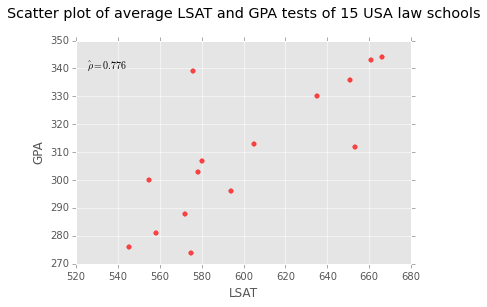

In [5]:
plt.scatter(law[:,0],lawdf.GPA,color=['red'],alpha=0.7)
plt.xlabel('LSAT')
plt.ylabel('GPA')
plt.title('Scatter plot of average LSAT and GPA tests of 15 USA law schools', y=1.08)
plt.text(525,340,r'$\hat{\rho} = 0.776$')
plt.show()

This plot suggests that there is a linear relation between the two scores. The **estimated correlation coefficient** $\hat{\rho}$ between LSAT and GPA is about 0.78 .

In [3]:
obsCorr = np.corrcoef(law[:,0],law[:,1])[0,1]
lawdf.corr()

,LSAT,GPA
LSAT,1.000000,0.776374
GPA,0.776374,1.000000


If we assume that the probability distribution $F$ of the two variables is bivariate normal, then the standard error of the estimated correlation coefficient is given by the following formula:

$$ \hat{se}_{normal} = \dfrac{( 1 - \hat{corr}^2)} {\sqrt{n- 3}} $$

In [6]:
seForm = (1 - obsCorr)**2 / (math.sqrt(15 - 3))
seForm

0.014436172405434168

However, we can also estimate the distribution of this statistic using a **bootstrap** procedure. The benefit of this approach is that we *do not need to assume a distribution of the population*. It will also work for more complicated statistics where a closed-form solution is harder to obtain. We will showcase two different approaches: the non parametric and the parametric bootstrap.

The **non-parametric** bootstrap procedure consists of *resampling with replacement from the observed data*. In other words, we sample from the empirical distribution $\hat{F}$. Note that we always sample pairs of LSAT-GPA, since these observations are dependent.

In [10]:
def bootstrapResample(sample):
    """ This function returns a random sample of rows drawn with replacement from the provided array.
    
    Args: sample (numpy array): the observed data in array format (n x 2) from which to sample.
    
    Returns: bootstrapSample (numpy array): a new array with random rows sampled from the input.
    """
    n = len(sample) # bootstrap samples have the same size as the original sample
    bootstrapSample = sample[np.random.choice(n, n)] # random.choice returns a vector of size n with random digits
                                                     # between 0 and 14, then we slice the input array using this vector
    return bootstrapSample

bootstraps = bootstrapResample(law)

We can calculate the sample correlation coefficient based on this bootstrap sample, i.e. the **bootstrap replicate** $ \hat{\theta}^*(b) $. It will be close to the observed $\hat{\rho}$, but not exactly the same.

In [11]:
np.corrcoef(bootstraps[:,0],bootstraps[:,1])[0,1]

0.87417660016697596

Now we will create *a thousand bootstrap samples* and calculate the estimated correlation coefficients for each of them.

In [12]:
def bootstrapCorr(sample,replicates): # replicates is number of bootstraps sample to take
    """ 
This function returns the bootstrap replicates for the correlation coefficient based on the input sample.

Args: sample (numpy array): the observed data in array format (n x 2) from which to sample
      replicates (int): number of bootstrap samples to perform
          
Returns: bootstrapCorr (numpy array): a new array (replicates x 1) containing the bootstrap correlation coefficient for each bootstrap sample.
    """
    n = len(sample)
#     bootstrapSamples = np.zeros((replicates, n, 2))
    bootstrapCorr = np.zeros(replicates)
    for i in range(replicates):
        bootstrapSample = bootstrapResample(sample)
#         bootstrapSamples[i] = bootstrapSample
        bootstrapCorr[i] = np.corrcoef(bootstrapSample[:,0],bootstrapSample[:,1])[0,1]
    return bootstrapCorr
bootstrapCorr = bootstrapCorr(law,1000)
bootstrapCorr[0:10] # print first 10 bootstrap replicates

array([ 0.94790401,  0.60765439,  0.81362247,  0.80600117,  0.77286733,
        0.75017514,  0.88210262,  0.77160419,  0.53519311,  0.98134867])

We can plot each of the thousand bootstrap replicate correlation coefficients $\hat{\rho^*}$ in a **histogram**. This gives us an approximation of the sampling distribution of the correlation coefficient $\hat{\rho}$. 

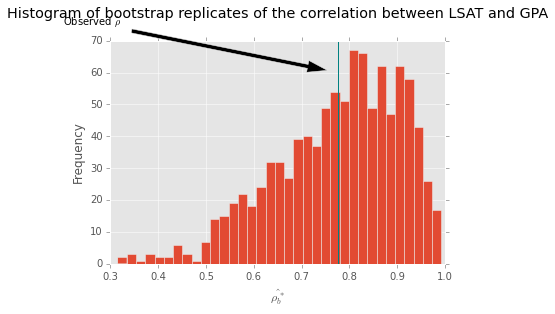

In [13]:
plt.hist(bootstrapCorr,bins=35)
plt.title("Histogram of bootstrap replicates of the correlation between LSAT and GPA",y=1.08)
plt.xlabel(r"$\hat{\rho^*_b}$")
plt.ylabel("Frequency")
plt.annotate(r'Observed $\hat{\rho}$', xy=(obsCorr, 60), xytext=(0.2, 75),
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.axvline(obsCorr,color='teal')
plt.show()

It is immediately obvious that the sampling distribution is skewed. This is to be expected for statistics with an upper or lower bound.

Based on this sampling distribution it is easy to calculate the **standard error of the correlation coefficient**. We just need to calculate the sample standard deviation of our bootstrap replicates:

$$ \hat{se}_B = \sqrt{\frac{\sum (\hat{\rho}^*_b - \hat{\rho}^*.)^2} {B-1}} $$

In [14]:
seCorr = np.std(bootstrapCorr, ddof=1)
seCorr

0.13128402360455518

The **parametric bootstrap** is very similar to the previous method, but rather than sampling from the empirical distribution (i.e. the observed sample), we resample from the assumed population distribution using the sample statistics as our distribution parameters. In this case we will assume a bivariate normal distribution for the LSAT and GPA variables: 

$$ x,y \sim \mathcal{N}(\mu_2,\sum) $$

where $\mu = (\bar{x},\bar{y})$

In [15]:
mean = np.mean(law,axis=0)
print(mean)

[ 600.26666667  309.46666667]


and $\sum = Cov(x_i,y_i) = \left(\begin{array}{cc}
\sum(x_i - \bar{x})^2 & \sum(x_i - \bar{x})(y_i - \bar{y}) \\
\sum(x_i - \bar{x})(y_i - \bar{y}) & \sum(y_i - \bar{y})^2
\end{array} \right )$

In [16]:
cov = np.cov(law,rowvar=0)
print(cov)

[[ 1746.78095238   790.15238095]
 [  790.15238095   592.98095238]]


In [25]:
def paramBootstrapResample(sample,replicates):
    """ This function returns a random sample of x,y pairs drawn from a bivariate normal distribution based on the provided sample.
    
    Args: sample (numpy array): the observed data in array format (n x 2) from which to sample.
          replicates (int): number of bootstrap samples to generate
    
    Returns: paramBootstrapSamples (numpy array): x,y arrays with random variables sampled from the multivariate distribution based on the provided 
                                 sample, of size replicates x sample
    """
    n = len(sample) # bootstrap samples have the same size as the original sample
    mean = np.mean(sample,axis=0) # calculate the mean vector for x,y
    cov = np.cov(law,rowvar=0) # calculate the covariance matrix for x,y
    paramBootstrapSamples = np.random.multivariate_normal(mean,cov,(n,replicates)).T
    return paramBootstrapSamples

paramBootstraps = paramBootstrapResample(law,1000)

We can plot the first three samples (each of size 15) to showcase the process.

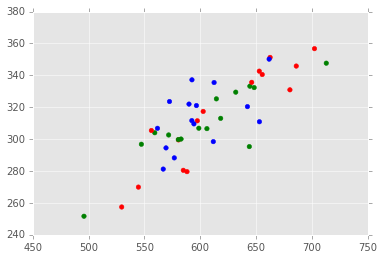

In [26]:
for index,group in enumerate(paramBootstraps[0,0:3]):
    plt.scatter(group, paramBootstraps[1,0:3][index], color=['red','green','blue'])
plt.show()

As before we can calculate a correlation coefficient for each of these bootstrap samples and also find the sample standard deviation of these replicates.

In [27]:
def paramBootstrapCorr(bootstrapSamples):
    """ 
    This function returns the bootstrap replicates for the correlation coefficient based on the provided bootstrap samples.

    Args: sample (numpy array): the bootstrap samples in array format (2 x B x n)
          
    Returns: paramBootstrapCorr (numpy array): a new array (B x 1) containing the bootstrap correlation coefficient for
    each bootstrap sample.
    """
    n,B,n = bootstrapSamples.shape
    paramBootstrapCorr = np.zeros(B)
    for i in range(B):
        paramBootstrapCorr[i] = np.corrcoef(bootstrapSamples[0,i],bootstrapSamples[1,i])[0,1]
    return paramBootstrapCorr
paramBootstrapCorr = paramBootstrapCorr(paramBootstraps)
bootstrapCorr[0:10] # print first 10 bootstrap replicates

array([ 0.94790401,  0.60765439,  0.81362247,  0.80600117,  0.77286733,
        0.75017514,  0.88210262,  0.77160419,  0.53519311,  0.98134867])

And again we can create a **histogram** to approximate the sampling distribution of the correlation coefficient $\hat{\rho}$. 

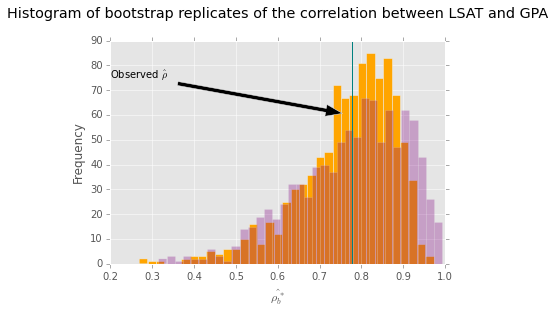

In [28]:
plt.hist(paramBootstrapCorr,bins=35,color='orange',alpha=1)
plt.hist(bootstrapCorr,bins=35,alpha=0.3,color='purple')
plt.title("Histogram of bootstrap replicates of the correlation between LSAT and GPA",y=1.08)
plt.xlabel(r"$\hat{\rho^*_b}$")
plt.ylabel("Frequency")
plt.annotate(r'Observed $\hat{\rho}$', xy=(obsCorr, 60), xytext=(0.2, 75),
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.axvline(obsCorr,color='teal')
# Parametric bootstrap in orange
plt.show()

The **standard error of the correlation coefficient** is calculated in the same manner as before. It's very close to the non parametric estimate.

In [29]:
seParamCorr = np.std(paramBootstrapCorr, ddof=1)
seParamCorr # parametric se

0.11373753431067481

In [30]:
seCorr # non parametric se

0.13128402360455518

## Question 2: Mean and variance of GPA

We can estimate the mean of GPA using the **sample mean**:

$$\bar{x} = \frac{1}{N} \sum\limits_{i=1}^N x_i$$

In [31]:
np.mean(lawdf.GPA)

309.46666666666664

The **sample variance** is given by:

$$ s^2 = \frac{1}{N-1}\sum\limits_{i = 1}^N {\left( {x_i - \bar x} \right)^2 } $$

In [32]:
np.var(lawdf.GPA)

553.44888888889307

We can use the same *bootstrapResample* function again to generate a random sample from the empirical distribution $\hat{F}$ by **generating samples with replacement** from the observed GPA results.

In [34]:
bootstrapResample(np.array(lawdf.GPA)) # bootstrapResample(law[:,1])

array([ 274.,  300.,  313.,  288.,  313.,  343.,  330.,  296.,  274.,
        312.,  276.,  312.,  276.,  344.,  344.])

When we repeat the process a *thousand times* and calculate the bootstrap sample means/sample variances (**bootstrap replicates**) we can generate a **histogram** and calculate the **standard errors** as before, i.e. the sample standard deviation of our bootstrap replicates:

$$ \hat{se}_B = \sqrt{\frac{\sum (\bar{x}^*_b - \bar{x}^*.)^2} {B-1}} $$

In [113]:
def bootstrapMean(sample,replicates): # replicates is number of bootstraps sample to take
    """ 
This function returns the bootstrap replicates for the mean based on the input sample.

Args: sample (numpy array): the observed data in array format (n x 1) from which to sample
      replicates (int): number of bootstrap samples to perform
          
Returns: bootstrapCorr (numpy array): a new array (replicates x 1) containing the means for each bootstrap sample.
    """
    n = len(sample)
    bootstrapMean = np.zeros(replicates)
    for i in range(replicates):
        bootstrapSample = bootstrapResample(sample)
        bootstrapMean[i] = np.mean(bootstrapSample)
    return bootstrapMean

bootstrapMeans = bootstrapMean(np.array(lawdf.GPA),1000)
bootstrapMeans[0:10] # print first 10 bootstrap replicates

array([ 306.        ,  315.86666667,  314.06666667,  308.86666667,
        321.53333333,  309.4       ,  319.73333333,  320.46666667,
        306.8       ,  307.2       ])

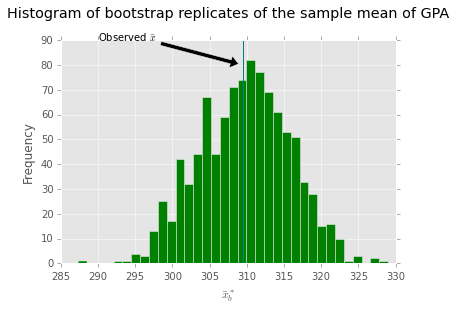

In [115]:
plt.hist(bootstrapMeans,bins=35,color='g')
plt.title("Histogram of bootstrap replicates of the sample mean of GPA",y=1.08)
plt.xlabel(r"$\bar{x}^*_b$")
plt.ylabel("Frequency")
plt.annotate(r'Observed $\bar{x}$', xy=(np.mean(lawdf.GPA), 80), xytext=(290, 90),
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.axvline(np.mean(lawdf.GPA),color='teal')
plt.show()

In [151]:
seMean = np.std(bootstrapMeans, ddof=1)
seMean

6.0907166192533664

We can compare this value to the theoretical standard error of the sample mean, based on the central limit theorem which tells us that the sampling distribution of the sample mean is given by: $ \bar{X}\sim N(\mu,\dfrac{\sigma^{2}}{n})$, which we can approximate by plugging in the sample variance:

$$ \text{SE}_\bar{x}\ = \frac{s}{\sqrt{n}} $$

In [152]:
np.std(np.array(lawdf.GPA))/math.sqrt(15)

6.0742565464913136

As you can see the bootstrap result is quite close to the classical one.

We can do the same thing for the **sample variance**: generate *bootstrap samples*, calculate the *bootstrap replicates*, generate a *histogram* and calculate the *standard error*.

In [153]:
def bootstrapVar(sample,replicates): # replicates is number of bootstraps sample to take
    """ 
This function returns the bootstrap replicates for the mean based on the input sample.

Args: sample (numpy array): the observed data in array format (n x 1) from which to sample
      replicates (int): number of bootstrap samples to perform
          
Returns: bootstrapCorr (numpy array): a new array (replicates x 1) containing the means for each bootstrap sample.
    """
    n = len(sample)
    bootstrapVar = np.zeros(replicates)
    for i in range(replicates):
        bootstrapSample = bootstrapResample(sample)
        bootstrapVar[i] = np.var(bootstrapSample)
    return bootstrapVar
bootstrapVars = bootstrapVar(np.array(lawdf.GPA),1000)
bootstrapVars[0:10] # print first 10 bootstrap replicates

array([ 421.97333333,  647.17333333,  687.42222222,  489.84      ,
        357.44888889,  634.59555556,  461.02222222,  611.49333333,
        726.72888889,  848.16      ])

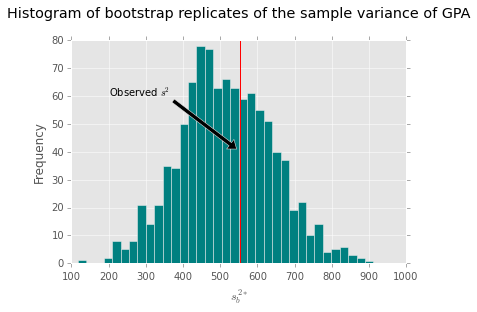

In [154]:
plt.hist(bootstrapVars,bins=35,color='teal')
plt.title("Histogram of bootstrap replicates of the sample variance of GPA",y=1.08)
plt.xlabel(r"$s^{2*}_b$")
plt.ylabel("Frequency")
plt.annotate(r'Observed $s^2$', xy=(np.var(lawdf.GPA), 40), xytext=(200, 60),
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.axvline(np.var(lawdf.GPA),color='red')
plt.show()

In [155]:
seVar = np.std(bootstrapVars, ddof=1)
seVar

125.19543999073207

The standard error of the sample variance is given by: $$ \sqrt{\frac{2\sigma^4 }{n-1}} $$

Oddly, this estimate is quite different from the bootstrap one and he histogram does not suggest a $\chi^2$ distribution either.

In [156]:
math.sqrt(2*np.var(np.array(lawdf.GPA))**2 / (len(lawdf.GPA) - 1) )

209.1840176264312

The estimate based on the fourth moment comes closer: $${\sigma^4\,(n-3)\over n\,(n-1)}$$.

In [157]:
math.sqrt((np.var(np.array(lawdf.GPA))**2 * (len(lawdf.GPA) - 3) ) / (len(lawdf.GPA) * ((len(lawdf.GPA) - 1))))

132.29958916086636

One possible explanation for the discrepancy is that the first formula assumes a normal distribution for GPA, which might not be correct.

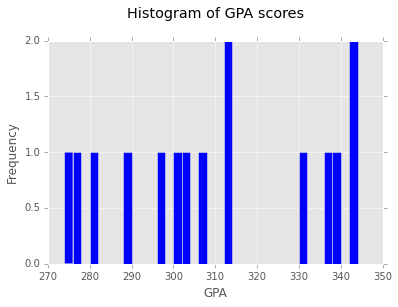

In [158]:
plt.hist(lawdf.GPA,bins=35,color='blue')
plt.title("Histogram of GPA scores",y=1.08)
plt.xlabel(r"GPA")
plt.ylabel("Frequency")
plt.show()

#### How many bootstrap samples do we need?

Now we'll compare the results for different amounts of bootstrap samples, starting with the sample mean.

25: ------------------    5.11940824127


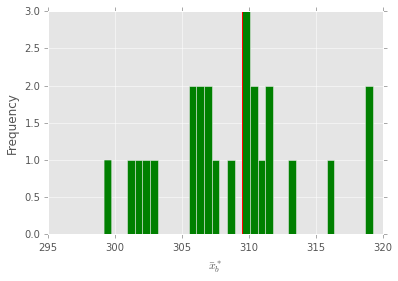

50: ------------------    6.63697004879


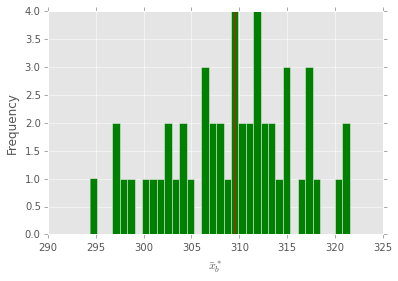

75: ------------------    6.28959768499


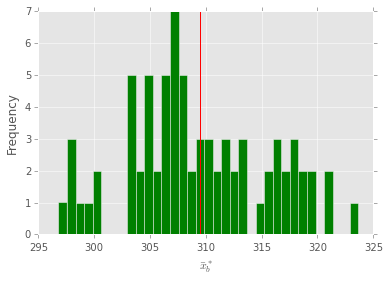

100: ------------------    6.55701760789


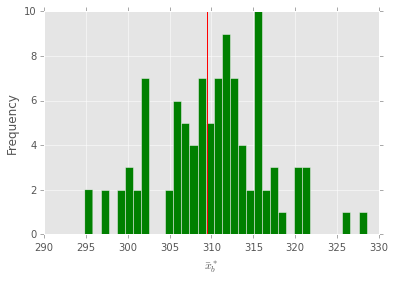

2500: ------------------    5.96040520669


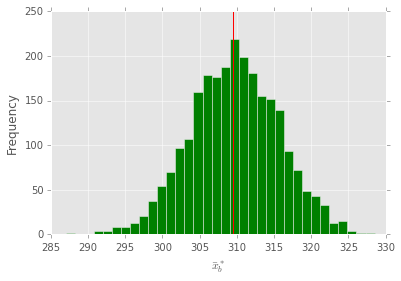

7500: ------------------    6.07729504782


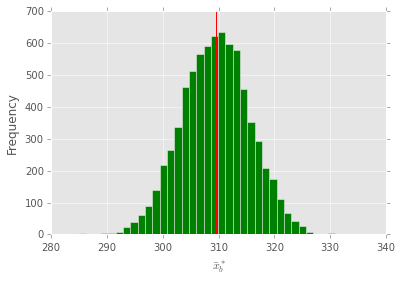

10000: ------------------    6.03952663155


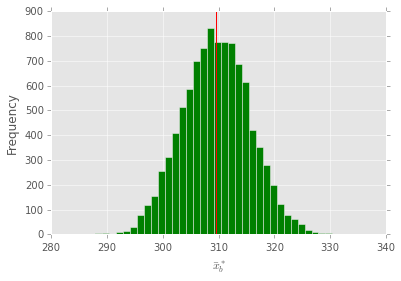

In [159]:
for i in [25,50,75,100,2500,7500,10000]:
    bootstrapMeans = bootstrapMean(np.array(lawdf.GPA),i)
    seM = np.std(bootstrapMeans, ddof=1)
    print(str(i)+': '.ljust(20, '-') + str(seM).rjust(17))
    plt.hist(bootstrapMeans,bins=35,color='g')
    plt.xlabel(r"$\bar{x}^*_b$")
    plt.ylabel("Frequency")
    plt.axvline(np.mean(lawdf.GPA),color='red')
    plt.show()

And now the **sample variance**:

25: ------------------     88.575952776


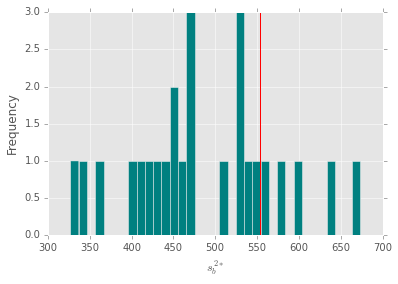

50: ------------------    128.279729652


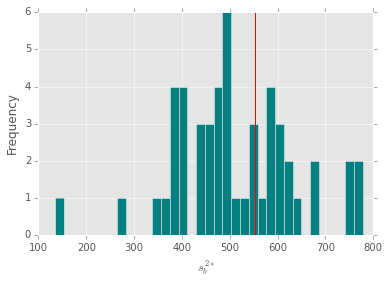

75: ------------------    126.597469713


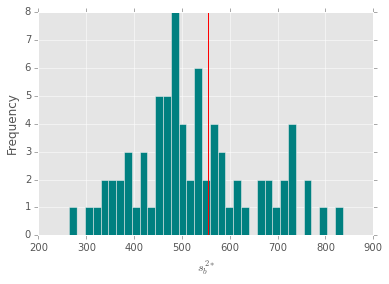

100: ------------------    124.243451477


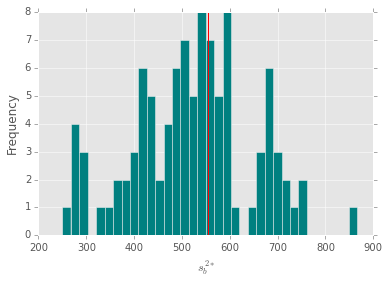

2500: ------------------     125.03207296


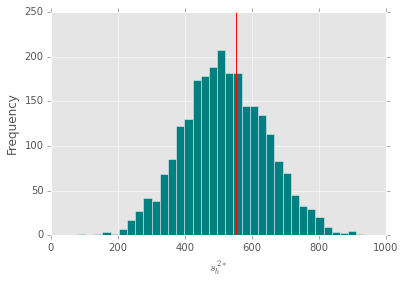

7500: ------------------    122.050771292


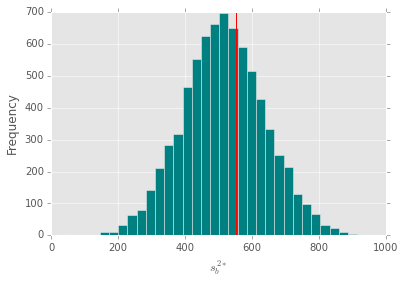

10000: ------------------    122.425518245


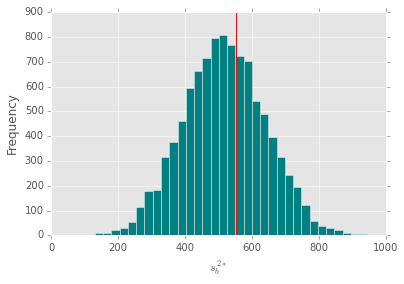

In [164]:
for i in [25,50,75,100,2500,7500,10000]:
    bootstrapVars = bootstrapVar(np.array(lawdf.GPA),i)
    seV = np.std(bootstrapVars, ddof=1)
    print(str(i)+': '.ljust(20, '-') + str(seV).rjust(17))
    plt.hist(bootstrapVars,bins=35,color='teal')
    plt.xlabel(r"$s^{2*}_b$")
    plt.ylabel("Frequency")
    plt.axvline(np.var(lawdf.GPA),color='red')
    plt.show()

## Question 3: Maximum wind speed

In [166]:
wind = np.array([7.4, 8, 12.6, 11.5, 14.3, 14.9, 8.6, 13.8, 20.1, 8.6, 6.9, 9.7, 9.2, 10.9, 13.2, 11.5, 12, 18.4, 11.5, 9.7, 9.7, 16.6, 9.7, 12, 16.6, 14.9, 8, 12, 14.9, 5.7, 7.4, 8.6, 9.7, 16.1, 9.2, 8.6, 14.3, 9.7, 6.9, 13.8, 11.5, 10.9, 9.2, 8, 13.8, 11.5, 14.9, 20.7, 9.2, 11.5, 10.3, 6.3, 1.7, 4.6, 6.3, 8, 8, 10.3, 11.5, 14.9, 8, 4.1, 9.2, 9.2, 10.9, 4.6, 10.9, 5.1, 6.3, 5.7, 7.4, 8.6, 14.3, 14.9, 14.9, 14.3, 6.9, 10.3, 6.3, 5.1, 11.5, 6.9, 9.7, 11.5, 8.6, 8, 8.6, 12, 7.4, 7.4, 7.4, 9.2, 6.9, 13.8, 7.4, 6.9, 7.4, 4.6, 4, 10.3, 8, 8.6, 11.5, 11.5, 11.5, 9.7, 11.5, 10.3, 6.3, 7.4, 10.9, 10.3, 15.5, 14.3, 12.6, 9.7, 3.4, 8, 5.7, 9.7, 2.3, 6.3, 6.3, 6.9, 5.1, 2.8, 4.6, 7.4, 15.5, 10.9, 10.3, 10.9, 9.7, 14.9, 15.5, 6.3, 10.9, 11.5, 6.9, 13.8, 10.3, 10.3, 8, 12.6, 9.2, 10.3, 10.3, 16.6, 6.9, 13.2, 14.3, 8, 11.5])

<function matplotlib.pyplot.show>

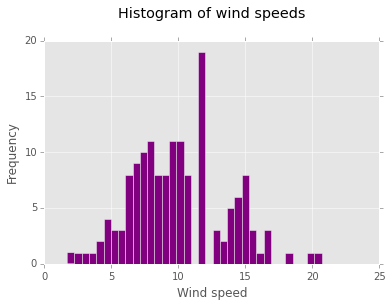

In [169]:
plt.hist(wind,bins=35,color='purple')
plt.title("Histogram of wind speeds",y=1.08)
plt.xlabel(r"Wind speed")
plt.ylabel("Frequency")
plt.show

In [171]:
np.max(wind)

20.699999999999999

### Non parametric bootstrap

In [197]:
def bootstrapMax(sample,replicates): # replicates is number of bootstraps sample to take
    """ 
This function returns the bootstrap replicates for the mean based on the input sample.

Args: sample (numpy array): the observed data in array format (n x 1) from which to sample
      replicates (int): number of bootstrap samples to perform
          
Returns: bootstrapCorr (numpy array): a new array (replicates x 1) containing the means for each bootstrap sample.
    """
    n = len(sample)
    bootstrapMaxs = np.zeros(replicates)
    for i in range(replicates):
        bootstrapSample = bootstrapResample(sample)
        bootstrapMaxs[i] = np.max(bootstrapSample)
    return bootstrapMaxs
bootstrapMaxs = bootstrapMax(np.array(wind),1000)
bootstrapMaxs[0:40] # print first 10 bootstrap replicates

array([ 20.7,  20.1,  20.7,  20.7,  20.7,  20.7,  20.1,  18.4,  20.1,
        20.1,  20.7,  20.7,  20.1,  20.7,  20.1,  20.1,  16.6,  20.7,
        20.7,  20.7,  20.7,  20.7,  20.1,  20.7,  20.7,  20.7,  20.7,
        20.1,  20.7,  20.1,  20.7,  18.4,  20.7,  20.7,  20.1,  20.7,
        20.1,  20.7,  20.7,  20.7])

In [198]:
seMax = np.std(bootstrapMaxs, ddof=1)
seMax

1.0616304532271192